In [1]:
 %%html
#Lets try using google trends data as an exogeneous factor to the original ARIMA model.
<h1> Forecast Using LSTM Model <h1>

In [1]:
import numpy as np
import pandas as pd

import os
import matplotlib.pyplot as plt
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [24]:
np.__version__

'1.19.5'

In [268]:
from datetime import date, datetime, timedelta
from pytrends.request import TrendReq
import time
import pandas as pd
import matplotlib
import gtrends
from IPython.core.display import display, HTML
from pytrends import dailydata
import yfinance as yf
#Request trending data from google
pytrend = TrendReq(hl='en-US')
keyword2 = 'Covid-19 Vaccine'
start = '2019-01-01'
end = '2021-12-01'
geo='US'
cat=0
gprop=''

cp = yf.Ticker("NVAX")

nvax = cp.history(start=start, end=end)



In [269]:
#Covid-19 Vaccine Trend/ can represent the need of vaccine

start_d = datetime.strptime(start, '%Y-%m-%d')
end_d = datetime.strptime(end, '%Y-%m-%d')
s_year = start_d.year
s_mon = start_d.month
e_year = end_d.year
e_mon = end_d.month

dailydata3 = dailydata.get_daily_data(word= keyword2,
                 start_year= s_year,
                 start_mon= s_mon,
                 stop_year= e_year,
                 stop_mon= e_mon,
                 geo= geo,
                 verbose= False,
                 wait_time = 1.0)

In [270]:
dailydata3

,Covid-19 Vaccine_unscaled,Covid-19 Vaccine_monthly,isPartial,scale,Covid-19 Vaccine
date,,,,,
2020-02-01,0,NaN,NaN,NaN,NaN
2020-02-02,0,0.0,False,0.00,0.00
2020-02-03,0,0.0,NaN,0.00,0.00
2020-02-04,0,0.0,NaN,0.00,0.00
2020-02-05,0,0.0,NaN,0.00,0.00
...,...,...,...,...,...
2021-12-10,65,11.0,NaN,0.11,7.15
2021-12-11,65,11.0,NaN,0.11,7.15
2021-12-12,39,9.0,True,0.09,3.51


In [271]:
vaccine_trend_stocks = pd.concat([dailydata3.loc[:,keyword2],nvax.Close],axis=1)
vaccine_trend_stocks.columns = ["Daily Trends","Stock Price"]
vaccine_trend_stocks

,Daily Trends,Stock Price
2019-01-02,NaN,39.400002
2019-01-03,NaN,40.799999
2019-01-04,NaN,42.799999
2019-01-07,NaN,45.200001
2019-01-08,NaN,46.000000
...,...,...
2021-12-10,7.15,NaN
2021-12-11,7.15,NaN
2021-12-12,3.51,NaN
2021-12-13,7.47,NaN


In [272]:
nvdata = vaccine_trend_stocks['Stock Price']
nvdata = nvdata.dropna()
nvdata


2019-01-02     39.400002
2019-01-03     40.799999
2019-01-04     42.799999
2019-01-07     45.200001
2019-01-08     46.000000
                 ...    
2021-11-23    200.710007
2021-11-24    200.070007
2021-11-26    217.970001
2021-11-29    193.960007
2021-11-30    208.630005
Name: Stock Price, Length: 735, dtype: float64

In [209]:
#normalize data

scaler = MinMaxScaler(feature_range=(0,1))

scaled_data = scaler.fit_transform(nvdata.values.reshape(-1,1))


In [210]:
# how many days do i want to base my predictions on ?
prediction_days = 60

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x - prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [211]:
def LSTM_model():
    
    model = Sequential()
    
    model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1],1)))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 50))
    model.add(Dropout(0.2))
    
    model.add(Dense(units=1))
    
    return model


In [23]:
conda uninstall numpy

Solving environment: failed

PackagesNotFoundError: The following packages are missing from the target environment:
  - numpy



Note: you may need to restart the kernel to use updated packages.


In [212]:
np.__version__

'1.19.5'

In [213]:
model = LSTM_model()
model.summary()
model.compile(optimizer='adam', 
              loss='mean_squared_error')


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 60, 50)            10400     
_________________________________________________________________
dropout_9 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 60, 50)            20200     
_________________________________________________________________
dropout_10 (Dropout)         (None, 60, 50)            0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dropout_11 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [214]:
# Define callbacks

# Save weights only for best model
checkpointer = ModelCheckpoint(filepath = 'weights_best.hdf5', 
                               verbose = 2, 
                               save_best_only = True)

history = model.fit(x_train, 
          y_train, 
          epochs=25, 
          batch_size = 32,
          callbacks = [checkpointer])

plt.figure(figsize = (15,8))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()


Train on 639 samples
Epoch 1/25


2021-12-16 00:45:17.453751: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_standard_lstm_44740_45225' and '__inference___backward_standard_lstm_44740_45225_specialized_for_StatefulPartitionedCall_1_at___inference_distributed_function_45878' both implement 'lstm_5b891847-dfa8-4021-9613-f8e8285e7b0c' but their signatures do not match.


639/639 [==============================] - 13s 20ms/sample - loss: 0.0269
Epoch 2/25
639/639 [==============================] - 7s 10ms/sample - loss: 0.0109
Epoch 3/25
639/639 [==============================] - 7s 11ms/sample - loss: 0.0099
Epoch 4/25
639/639 [==============================] - 7s 11ms/sample - loss: 0.0076
Epoch 5/25
639/639 [==============================] - 7s 11ms/sample - loss: 0.0082
Epoch 6/25
639/639 [==============================] - 7s 11ms/sample - loss: 0.0075
Epoch 7/25
639/639 [==============================] - 6s 10ms/sample - loss: 0.0069
Epoch 8/25
639/639 [==============================] - 7s 10ms/sample - loss: 0.0074
Epoch 9/25
639/639 [==============================] - 6s 10ms/sample - loss: 0.0060
Epoch 10/25
639/639 [==============================] - 6s 10ms/sample - loss: 0.0060
Epoch 11/25
639/639 [==============================] - 7s 10ms/sample - loss: 0.0058
Epoch 12/25
639/639 [==============================] - 6s 10ms/sample - loss: 0.0055

TypeError: from_bounds() argument after * must be an iterable, not int

In [220]:
history.history

{'loss': [0.026926272077972713,
  0.010876715592806795,
  0.009909626986271758,
  0.007623124616264318,
  0.008182856577108957,
  0.007495504457077976,
  0.006859768629482188,
  0.007433795429917755,
  0.006004958494430836,
  0.006040251238857496,
  0.00578370885610149,
  0.0054689986661881065,
  0.00533347018500309,
  0.005229023133269008,
  0.004900609745012949,
  0.004810670254451801,
  0.004225955972905636,
  0.004382403694961879,
  0.005410629121298102,
  0.005282111990619713,
  0.0046777581010474375,
  0.00402593909775917,
  0.0040624168904058065,
  0.004414552915258354,
  0.0039749324353811144]}

KeyError: 'val_loss'

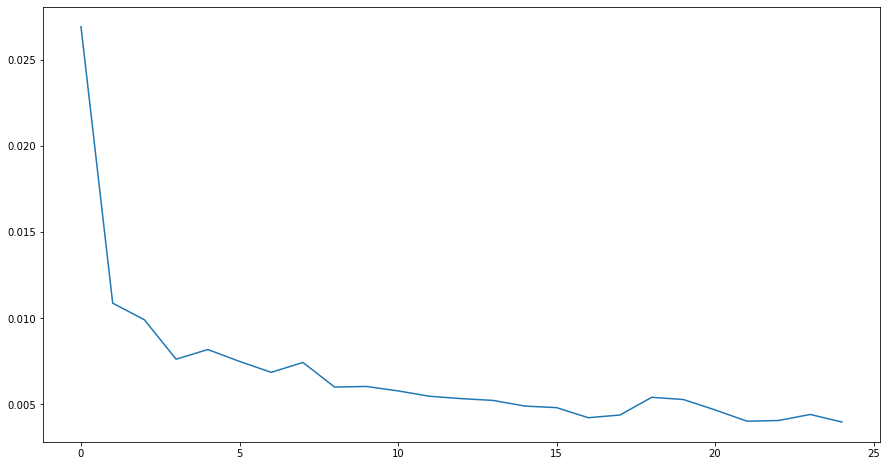

In [215]:

plt.figure(figsize = (15,8))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()



In [221]:
# test model accuracy on existing data

test_data = cp.history(start= end , end = dt.datetime.now())

actual_prices = test_data['Close'].values

total_dataset = pd.concat((nvdata, test_data['Close']), axis=0)

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

In [222]:
x_test = []
for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1] ,1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)


2021-12-16 01:14:33.353539: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_cudnn_lstm_with_fallback_47694' and '__inference_standard_lstm_47583_specialized_for_sequential_5_lstm_13_StatefulPartitionedCall_at___inference_distributed_function_48356' both implement 'lstm_a004c9cf-fd5d-4fbe-8c78-46c388635313' but their signatures do not match.


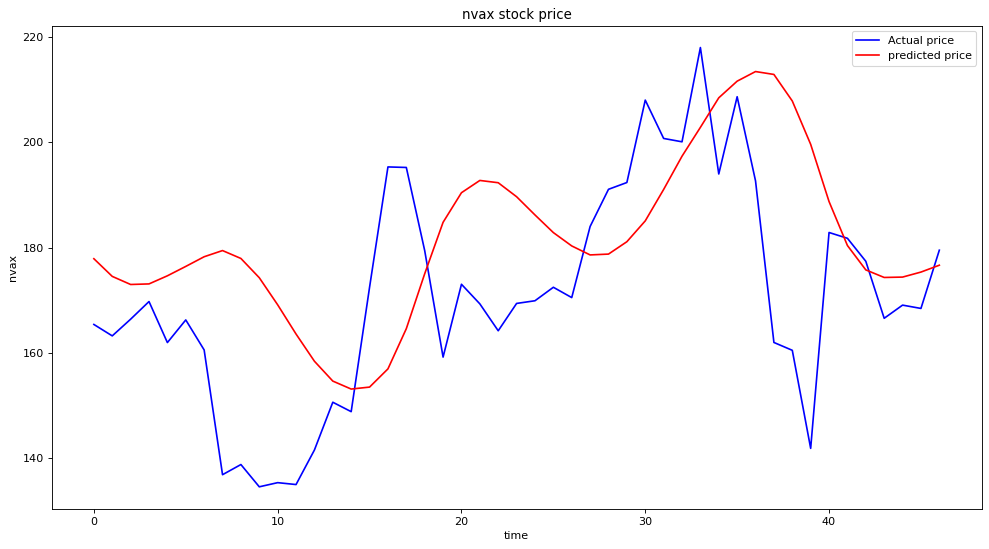

In [226]:
plt.figure(figsize=(15,8),dpi=80)
plt.plot(actual_prices, color='blue', label="Actual price")
plt.plot(predicted_prices, color= 'red', label="predicted price")
plt.title('nvax stock price')
plt.xlabel("time")
plt.ylabel("nvax" )
plt.legend()
plt.show()

In [227]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
# report performance
mse = mean_squared_error(actual_prices, predicted_prices)
print('MSE: '+str(mse))
mae = mean_absolute_error(actual_prices, predicted_prices)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(actual_prices, predicted_prices))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(predicted_prices - actual_prices)/np.abs(actual_prices))
print('MAPE: '+str(mape))


MSE: 515.5824323505649
MAE: 17.70271950579704
RMSE: 22.706440327593512
MAPE: 0.13599337888173835


In [41]:
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [273]:
df = pd.concat([nvax.Close,dailydata3.loc[:,keyword2]],axis=1)
df.reset_index(inplace=True)
df.columns = ['date','price','trend']
df = df.dropna()
df

,date,price,trend
275,2020-02-03,6.810000,0.00
276,2020-02-04,7.010000,0.00
277,2020-02-05,6.970000,0.00
278,2020-02-06,6.840000,0.00
279,2020-02-07,6.310000,0.00
...,...,...,...
934,2021-11-23,200.710007,6.16
935,2021-11-24,200.070007,6.05
937,2021-11-26,217.970001,6.38
940,2021-11-29,193.960007,8.76


In [274]:
#Separate dates for future plotting
train_dates = pd.to_datetime(df['date'])
print(train_dates.tail(15)) #Check last few dates. 


920   2021-11-09
921   2021-11-10
922   2021-11-11
923   2021-11-12
926   2021-11-15
927   2021-11-16
928   2021-11-17
929   2021-11-18
930   2021-11-19
933   2021-11-22
934   2021-11-23
935   2021-11-24
937   2021-11-26
940   2021-11-29
941   2021-11-30
Name: date, dtype: datetime64[ns]


In [275]:
#Separate dates for future plotting
train_dates_2 = pd.to_datetime(df['date'])
print(train_dates.tail(15)) #Check last few dates. 


920   2021-11-09
921   2021-11-10
922   2021-11-11
923   2021-11-12
926   2021-11-15
927   2021-11-16
928   2021-11-17
929   2021-11-18
930   2021-11-19
933   2021-11-22
934   2021-11-23
935   2021-11-24
937   2021-11-26
940   2021-11-29
941   2021-11-30
Name: date, dtype: datetime64[ns]


In [276]:
df_2 = df[['date','price']]

In [277]:
cols = list(df)[1:]
cols

['price', 'trend']

In [278]:
cols2 = list(df_2)[1:]
cols2

['price']

In [279]:
df_for_training_2 = df_2[cols2].astype(float)

In [280]:
df_for_training = df[cols].astype(float)

In [281]:
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [282]:
scaler_2 = StandardScaler()
scaler_2 = scaler_2.fit(df_for_training_2)
df_for_training_scaled_2 = scaler_2.transform(df_for_training_2)

In [283]:
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 7  # Number of past days we want to use to predict the future.


In [285]:
trainX_2 = []
trainY_2 = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 7  # Number of past days we want to use to predict the future.


In [284]:
#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))


trainX shape == (455, 7, 2).
trainY shape == (455, 1).


In [286]:
#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled_2) - n_future +1):
    trainX_2.append(df_for_training_scaled_2[i - n_past:i, 0:df_for_training_2.shape[1]])
    trainY_2.append(df_for_training_scaled_2[i + n_future - 1:i + n_future, 0])

trainX_2, trainY_2 = np.array(trainX_2), np.array(trainY_2)

print('trainX shape == {}.'.format(trainX_2.shape))
print('trainY shape == {}.'.format(trainY_2.shape))


trainX shape == (455, 7, 1).
trainY shape == (455, 1).


In [287]:

model_2 = Sequential()
model_2.add(LSTM(64, activation='relu', input_shape=(trainX_2.shape[1], trainX_2.shape[2]), return_sequences=True))
model_2.add(LSTM(32, activation='relu', return_sequences=False))
model_2.add(Dropout(0.2))
model_2.add(Dense(trainY_2.shape[1]))

model_2.compile(optimizer='adam', loss='mse')
model_2.summary()


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 7, 64)             16896     
_________________________________________________________________
lstm_20 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dropout_14 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 29,345
Trainable params: 29,345
Non-trainable params: 0
_________________________________________________________________


In [288]:

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()



Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 7, 64)             17152     
_________________________________________________________________
lstm_22 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dropout_15 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 33        
Total params: 29,601
Trainable params: 29,601
Non-trainable params: 0
_________________________________________________________________


Train on 409 samples, validate on 46 samples
Epoch 1/25
409/409 [==============================] - 3s 8ms/sample - loss: 0.9544 - val_loss: 0.2681
Epoch 2/25
409/409 [==============================] - 0s 981us/sample - loss: 0.6741 - val_loss: 0.1390
Epoch 3/25
409/409 [==============================] - 0s 954us/sample - loss: 0.2829 - val_loss: 0.0862
Epoch 4/25
409/409 [==============================] - 0s 975us/sample - loss: 0.1535 - val_loss: 0.0708
Epoch 5/25
409/409 [==============================] - 0s 1ms/sample - loss: 0.1478 - val_loss: 0.0741
Epoch 6/25
409/409 [==============================] - 0s 1ms/sample - loss: 0.1407 - val_loss: 0.0703
Epoch 7/25
409/409 [==============================] - 0s 1ms/sample - loss: 0.1253 - val_loss: 0.0650
Epoch 8/25
409/409 [==============================] - 0s 1ms/sample - loss: 0.1140 - val_loss: 0.0653
Epoch 9/25
409/409 [==============================] - 0s 1ms/sample - loss: 0.1180 - val_loss: 0.0587
Epoch 10/25
409/409 [==========

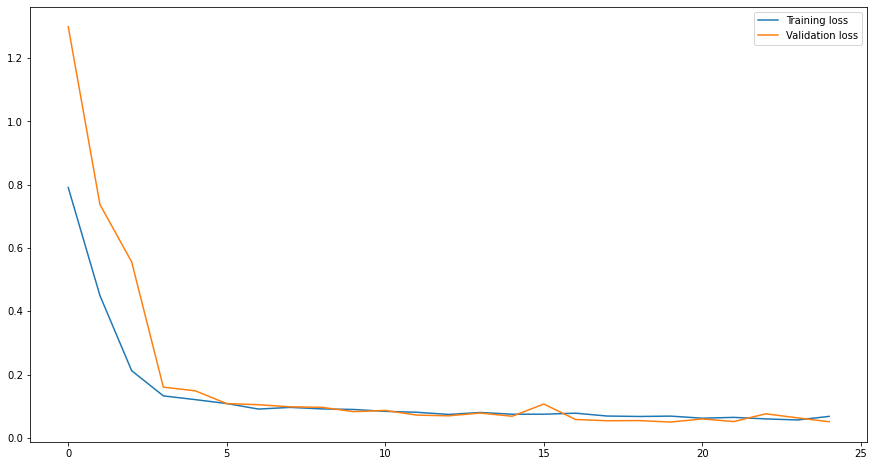

In [289]:
# fit the model
history_2 = model_2.fit(trainX_2, trainY_2, epochs=25, batch_size=32, validation_split=0.1, verbose=1)
plt.figure(figsize = (15,8))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()


Train on 409 samples, validate on 46 samples
Epoch 1/25
409/409 [==============================] - 4s 10ms/sample - loss: 0.8576 - val_loss: 0.3205
Epoch 2/25
409/409 [==============================] - 0s 1ms/sample - loss: 0.4525 - val_loss: 0.1964
Epoch 3/25
409/409 [==============================] - 0s 1ms/sample - loss: 0.1854 - val_loss: 0.0764
Epoch 4/25
409/409 [==============================] - 0s 979us/sample - loss: 0.1259 - val_loss: 0.1130
Epoch 5/25
409/409 [==============================] - 0s 988us/sample - loss: 0.1163 - val_loss: 0.0892
Epoch 6/25
409/409 [==============================] - 0s 1ms/sample - loss: 0.1012 - val_loss: 0.0771
Epoch 7/25
409/409 [==============================] - 0s 1ms/sample - loss: 0.1060 - val_loss: 0.0746
Epoch 8/25
409/409 [==============================] - 1s 1ms/sample - loss: 0.0977 - val_loss: 0.0651
Epoch 9/25
409/409 [==============================] - 0s 1ms/sample - loss: 0.0904 - val_loss: 0.0754
Epoch 10/25
409/409 [===========

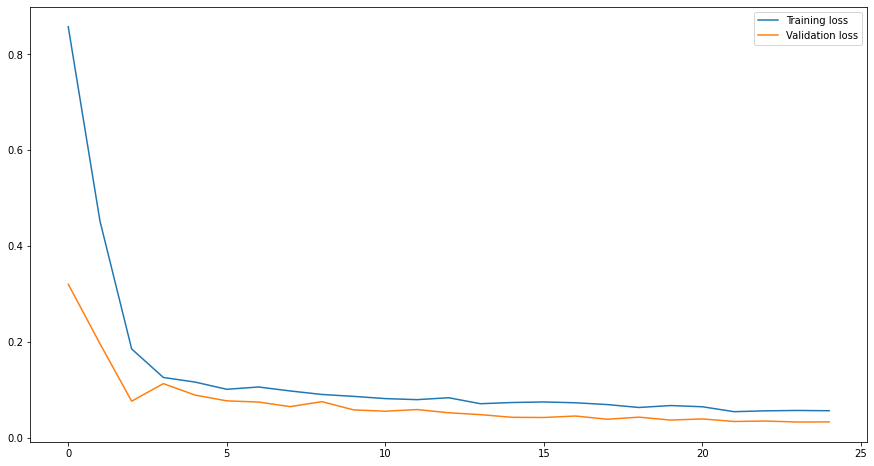

In [290]:
# fit the model
history = model.fit(trainX, trainY, epochs=25, batch_size=32, validation_split=0.1, verbose=1)
plt.figure(figsize = (15,8))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()


In [296]:
#as inputs for prediction. We only have all 5 variables until the last day in our dataset.
n_past =91
n_days_for_prediction=90  #let us predict past 15 days

predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq=us_bd).tolist()
print(predict_period_dates)


[Timestamp('2021-07-23 00:00:00', freq='C'), Timestamp('2021-07-26 00:00:00', freq='C'), Timestamp('2021-07-27 00:00:00', freq='C'), Timestamp('2021-07-28 00:00:00', freq='C'), Timestamp('2021-07-29 00:00:00', freq='C'), Timestamp('2021-07-30 00:00:00', freq='C'), Timestamp('2021-08-02 00:00:00', freq='C'), Timestamp('2021-08-03 00:00:00', freq='C'), Timestamp('2021-08-04 00:00:00', freq='C'), Timestamp('2021-08-05 00:00:00', freq='C'), Timestamp('2021-08-06 00:00:00', freq='C'), Timestamp('2021-08-09 00:00:00', freq='C'), Timestamp('2021-08-10 00:00:00', freq='C'), Timestamp('2021-08-11 00:00:00', freq='C'), Timestamp('2021-08-12 00:00:00', freq='C'), Timestamp('2021-08-13 00:00:00', freq='C'), Timestamp('2021-08-16 00:00:00', freq='C'), Timestamp('2021-08-17 00:00:00', freq='C'), Timestamp('2021-08-18 00:00:00', freq='C'), Timestamp('2021-08-19 00:00:00', freq='C'), Timestamp('2021-08-20 00:00:00', freq='C'), Timestamp('2021-08-23 00:00:00', freq='C'), Timestamp('2021-08-24 00:00:00'

In [297]:
#Make prediction
prediction = model.predict(trainX[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction

#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

In [298]:
#Make prediction
prediction_2 = model_2.predict(trainX_2[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction

#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
prediction_copies_2 = np.repeat(prediction_2, df_for_training.shape[1], axis=-1)
y_pred_future_2 = scaler.inverse_transform(prediction_copies_2)[:,0]

In [330]:
df_forecast

,date,price
0,2021-07-23,206.792938
1,2021-07-26,201.803345
2,2021-07-27,194.046371
3,2021-07-28,193.161789
4,2021-07-29,190.766647
...,...,...
85,2021-11-24,194.208878
86,2021-11-26,197.387955
87,2021-11-29,198.744080
88,2021-11-30,204.212708


/Users/wwy/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


Text(0.5, 1.0, 'LSTM + Trend Forecast Result')

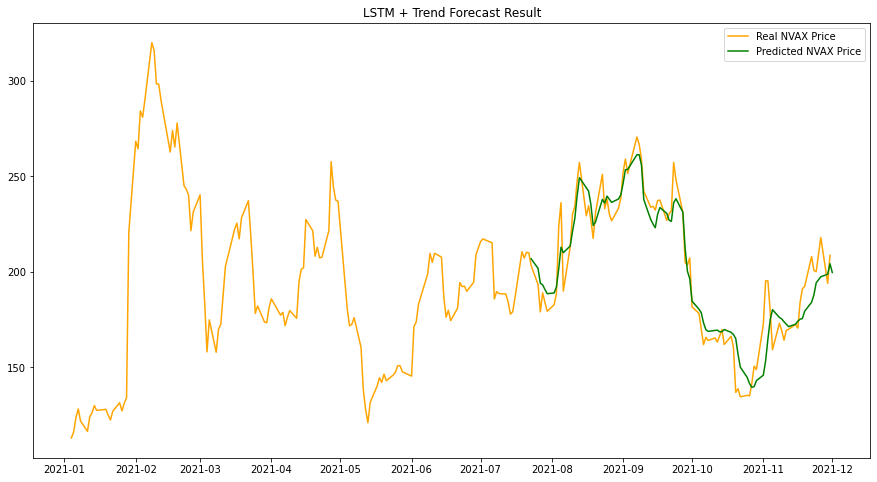

In [299]:

# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'date':np.array(forecast_dates), 'price':y_pred_future})
df_forecast['date']=pd.to_datetime(df_forecast['date'])


original = df[['date', 'price']]
original['date']=pd.to_datetime(original['date'])
original = original.loc[original['date'] >= '2021-1-1']



plt.figure(figsize = (15,8))
plt.plot(original['date'], original['price'],color = 'orange', label = 'Real NVAX Price')
plt.plot(df_forecast['date'], df_forecast['price'],color = 'green', label = 'Predicted NVAX Price')
plt.legend(loc = 'best')
plt.title('LSTM + Trend Forecast Result')


/Users/wwy/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


Text(0.5, 1.0, 'LSTM Forecast Result')

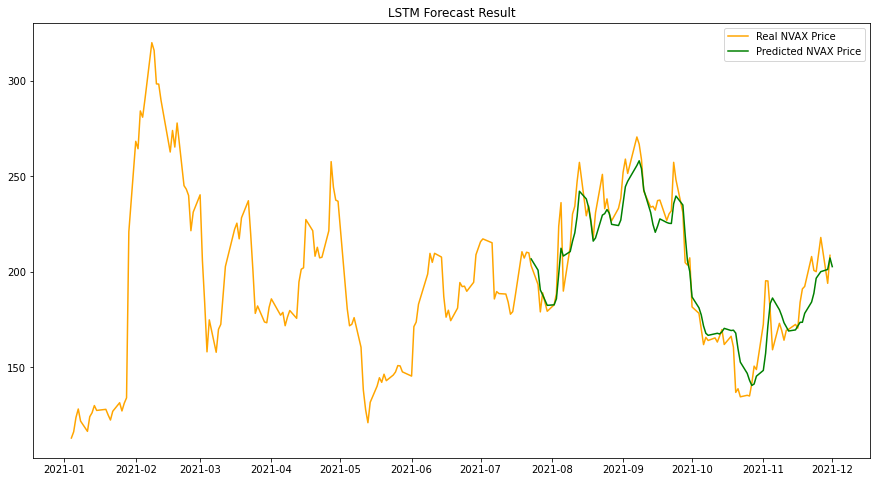

In [301]:

# Convert timestamp to date
forecast_dates_2 = []
for time_i in predict_period_dates:
    forecast_dates_2.append(time_i.date())
    
df_forecast_2 = pd.DataFrame({'date':np.array(forecast_dates_2), 'price':y_pred_future_2})
df_forecast_2['date']=pd.to_datetime(df_forecast_2['date'])


original = df[['date', 'price']]
original['date']=pd.to_datetime(original['date'])
original = original.loc[original['date'] >= '2021-1-1']



plt.figure(figsize = (15,8))
plt.plot(original['date'], original['price'],color = 'orange', label = 'Real NVAX Price')
plt.plot(df_forecast_2['date'], df_forecast_2['price'],color = 'green', label = 'Predicted NVAX Price')
plt.legend(loc = 'best')
plt.title('LSTM Forecast Result')


/Users/wwy/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


Text(0.5, 1.0, 'Novavax Stock Price Prediction')

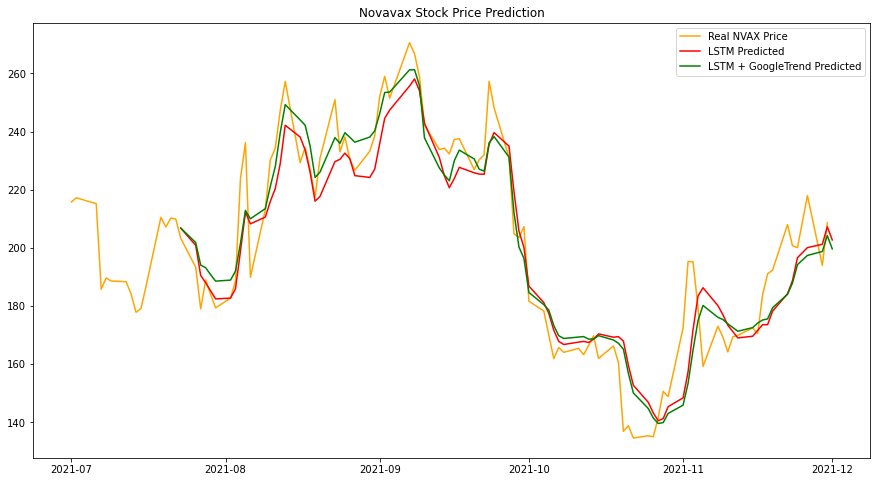

In [303]:
# Convert timestamp to date
forecast_dates_2 = []
for time_i in predict_period_dates:
    forecast_dates_2.append(time_i.date())
    
df_forecast_2 = pd.DataFrame({'date':np.array(forecast_dates_2), 'price':y_pred_future_2})
df_forecast_2['date']=pd.to_datetime(df_forecast_2['date'])


original = df[['date', 'price']]
original['date']=pd.to_datetime(original['date'])
original = original.loc[original['date'] >= '2021-7-1']



plt.figure(figsize = (15,8))
plt.plot(original['date'], original['price'],color = 'orange', label = 'Real NVAX Price')
plt.plot(df_forecast_2['date'], df_forecast_2['price'],color = 'red', label = 'LSTM Predicted')
plt.plot(df_forecast['date'], df_forecast['price'],color = 'green', label = 'LSTM + GoogleTrend Predicted')
plt.legend(loc = 'best')
plt.title('Novavax Stock Price Prediction')


In [315]:
fc = df_forecast[df_forecast['date'] < '2021-12-01']
fc

,date,price
0,2021-07-23,206.792938
1,2021-07-26,201.803345
2,2021-07-27,194.046371
3,2021-07-28,193.161789
4,2021-07-29,190.766647
...,...,...
84,2021-11-23,187.889969
85,2021-11-24,194.208878
86,2021-11-26,197.387955
87,2021-11-29,198.744080


In [316]:
fc2 = df_forecast_2[df_forecast['date'] < '2021-12-01']
fc2

,date,price
0,2021-07-23,206.752090
1,2021-07-26,200.851761
2,2021-07-27,190.510345
3,2021-07-28,187.974091
4,2021-07-29,185.194748
...,...,...
84,2021-11-23,188.752579
85,2021-11-24,196.622101
86,2021-11-26,200.069504
87,2021-11-29,201.216110


In [317]:
test_data = original[original["date"] >= '2021-07-23']
test_data

,date,price
811,2021-07-23,203.240005
814,2021-07-26,193.360001
815,2021-07-27,179.009995
816,2021-07-28,189.009995
817,2021-07-29,184.000000
...,...,...
934,2021-11-23,200.710007
935,2021-11-24,200.070007
937,2021-11-26,217.970001
940,2021-11-29,193.960007


In [343]:
test_data = test_data[test_data["date"] != '2021-10-11']


In [344]:
fc.tail(40)

,date,price
49,2021-10-01,184.635406
50,2021-10-04,180.455109
51,2021-10-05,178.577042
52,2021-10-06,173.270569
53,2021-10-07,169.758621
54,2021-10-08,168.814362
55,2021-10-12,169.465866
56,2021-10-13,168.598419
57,2021-10-14,168.619919
58,2021-10-15,169.782959


In [345]:
test_data.tail(40)

,date,price
881,2021-10-01,181.600006
884,2021-10-04,178.270004
885,2021-10-05,170.000000
886,2021-10-06,161.889999
887,2021-10-07,165.679993
888,2021-10-08,164.050003
892,2021-10-12,163.220001
893,2021-10-13,166.389999
894,2021-10-14,169.740005
895,2021-10-15,161.949997


In [346]:
fc = fc.price
fc2 = fc2.price
test_data = test_data.price

In [347]:
# report LSTM performance
mse = mean_squared_error(test_data, fc2)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc2)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc2))
print('RMSE: '+str(rmse))
test_data = test_data.squeeze()
mape = np.mean(np.abs(fc2 - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 152.0434082698501
MAE: 9.3807018151444
RMSE: 12.3305883180751
MAPE: nan


In [348]:
# report LSTM+trend performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
test_data = test_data.squeeze()
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 135.19070133358616
MAE: 8.858654922313905
RMSE: 11.627153621311889
MAPE: nan


In [ ]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
test_data = test_data.squeeze()
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MAPE: nan
